In [1]:
using DifferentialEquations, Plots, Rsvg, DiffEqProblemLibrary
gr()

Plots.GRBackend()

# Model and example solutions
Here we implement a 1D continuous time random walk approximation of diffusion for $N$ lattice sites, with reflecting boundary conditions

In [18]:
N = 256
jprob = prob_jump_diffnetwork
rn = jprob.network(N)
rnpar = jprob.rates
u0 = jprob.u0(N)
tf = jprob.tstop

10.0

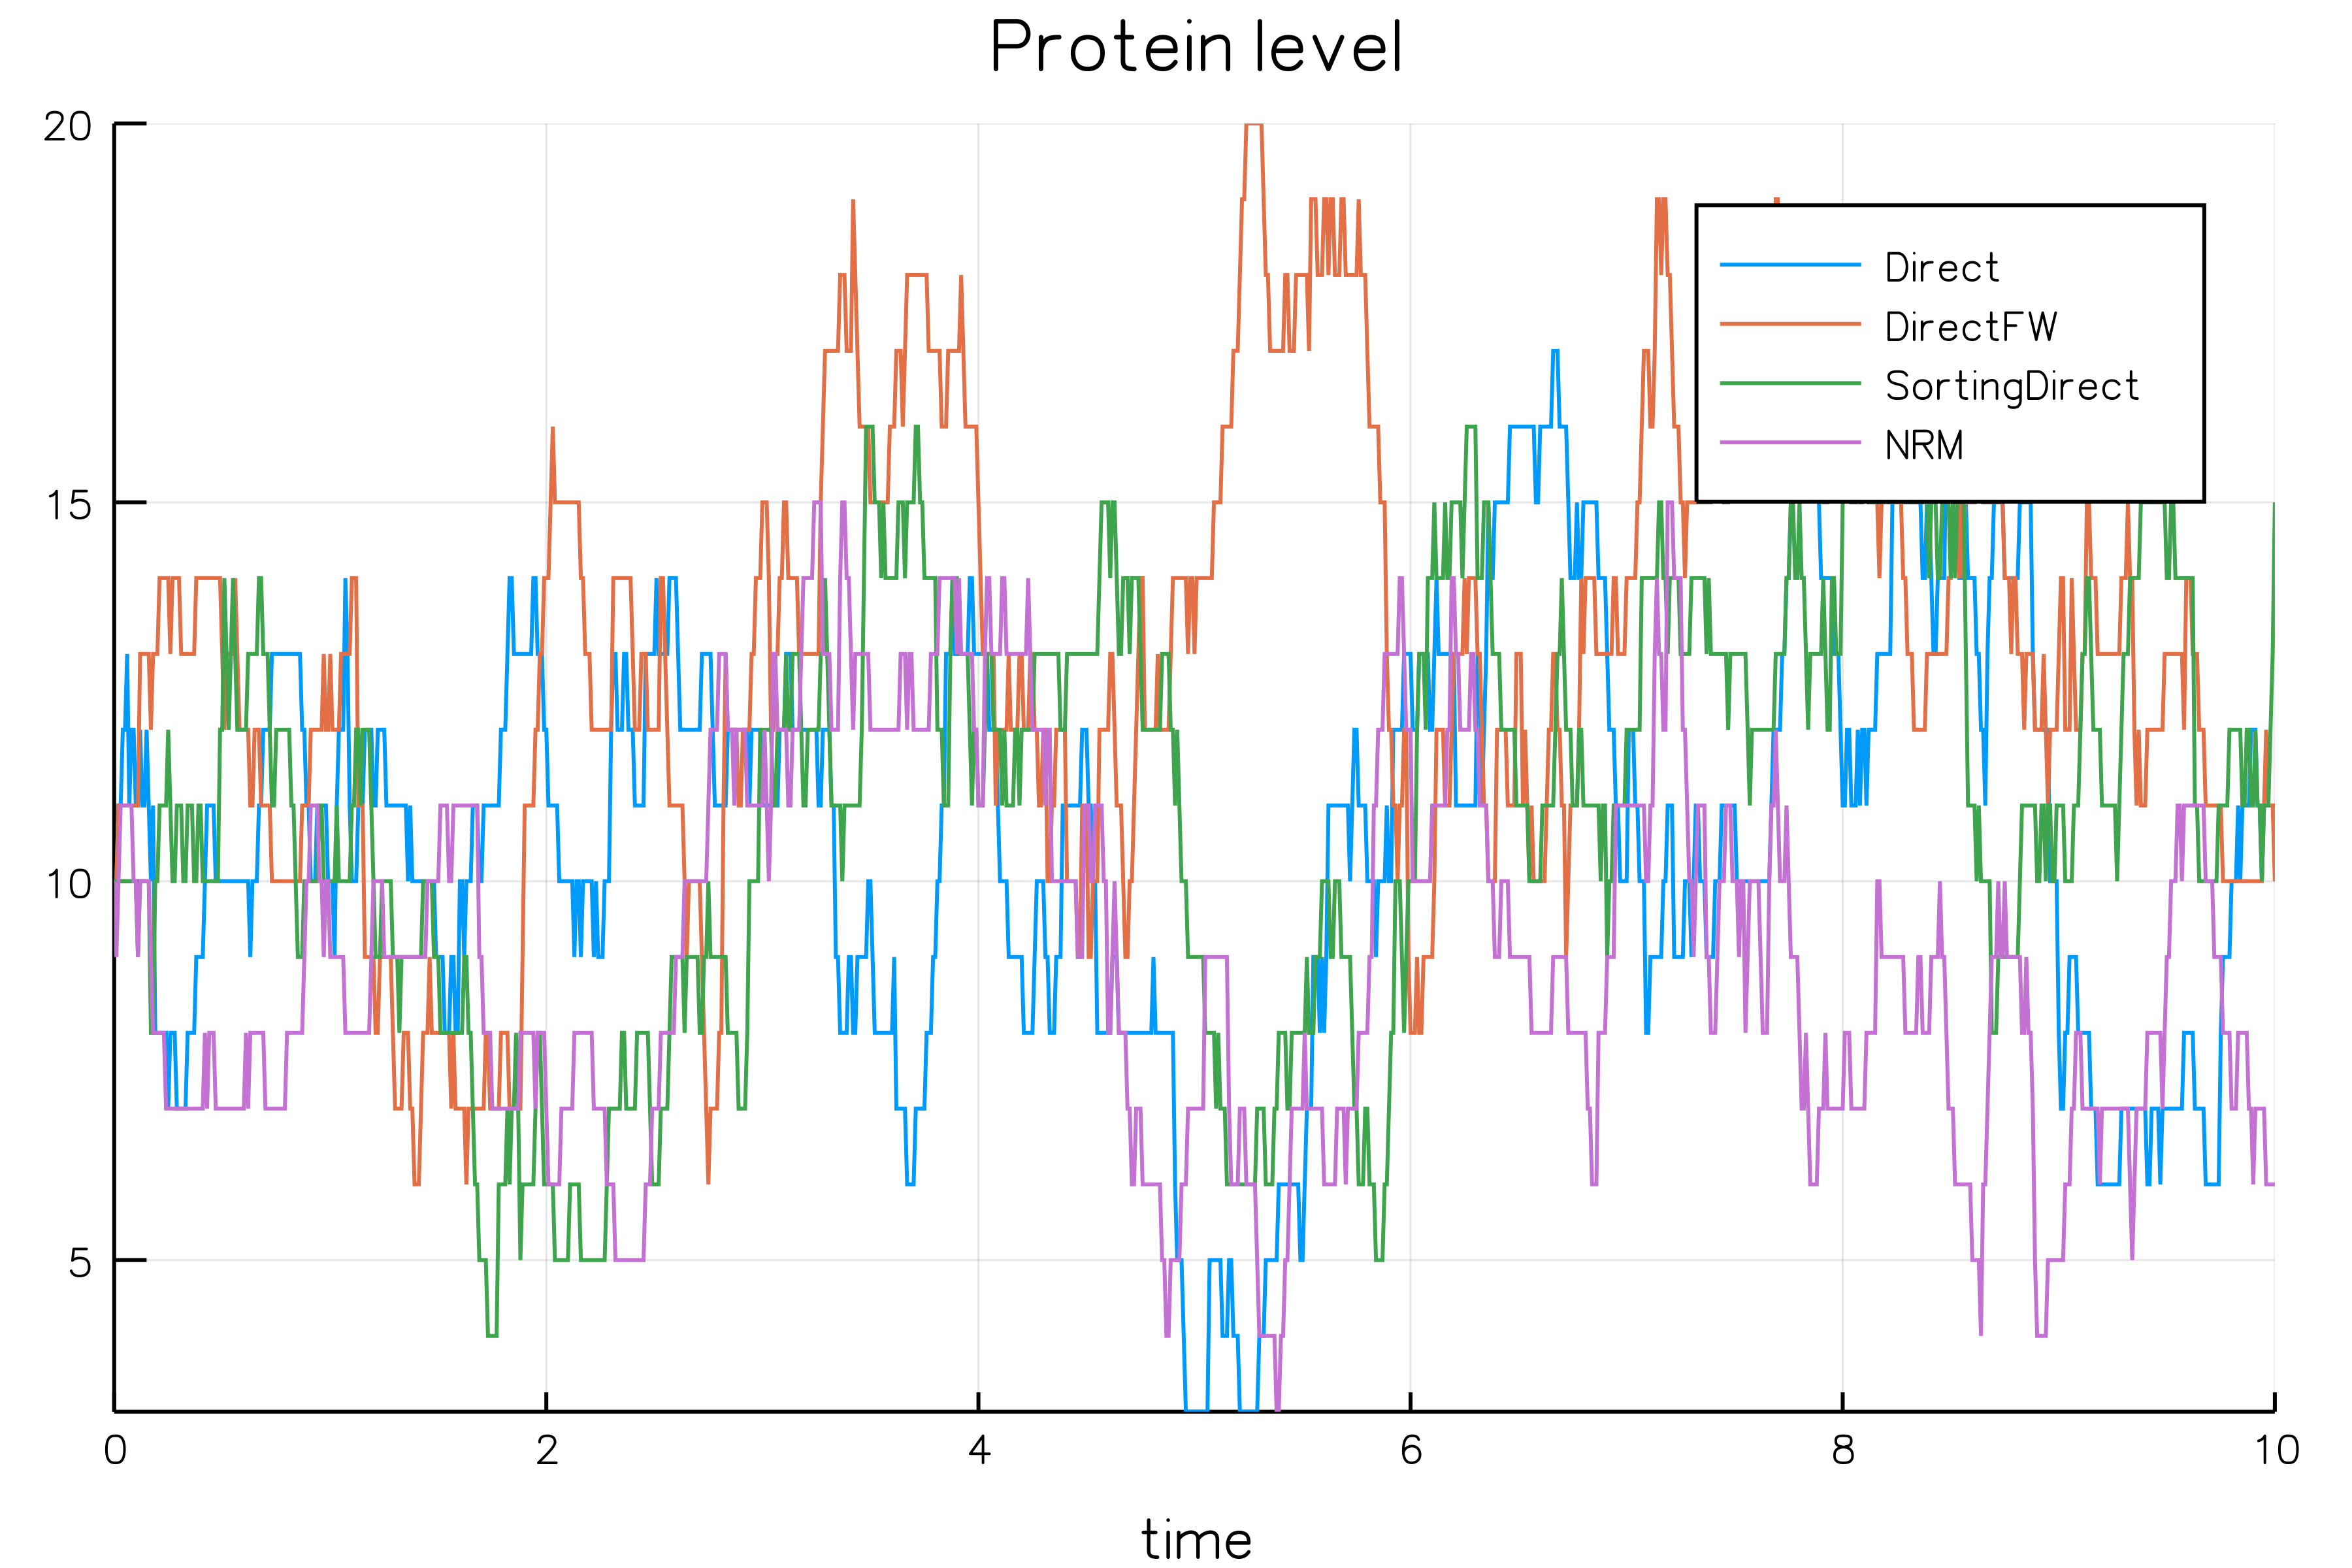

In [19]:
methods = (Direct(),DirectFW(),SortingDirect(),NRM())
legs    = [typeof(method) for method in methods]
shortlabels = [string(leg)[12:end] for leg in legs]
fmt     = :png
prob    = prob = DiscreteProblem(u0, (0.0, tf), rnpar)
ploth   = plot(reuse=false)
for (i,method) in enumerate(methods)
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    sol = solve(jump_prob, SSAStepper(), saveat=tf/1000.)
    plot!(ploth,sol.t,sol[Int(N//2),:],label=shortlabels[i], format=fmt)
end
plot(ploth, title="Protein level", xlabel="time",format=fmt)

# Benchmarking performance of the methods

In [20]:
function run_benchmark!(t, jump_prob, stepper)
    sol = solve(jump_prob, stepper)
    @inbounds for i in 1:length(t)
        t[i] = @elapsed (sol = solve(jump_prob, stepper))
    end
end

run_benchmark! (generic function with 1 method)

In [23]:
nsims = 50
benchmarks = Vector{Vector{Float64}}()
gc()
for method in methods
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    stepper = SSAStepper()
    t = Vector{Float64}(nsims)
    run_benchmark!(t, jump_prob, stepper)
    push!(benchmarks, t)
end

In [28]:
medtimes = Vector{Float64}(length(methods))
stdtimes = Vector{Float64}(length(methods))
avgtimes = Vector{Float64}(length(methods))
for i in 1:length(methods)
    medtimes[i] = median(benchmarks[i])
    avgtimes[i] = mean(benchmarks[i])
    stdtimes[i] = std(benchmarks[i])
end
using DataFrames
# convert times to units of seconds
df = DataFrame(names=shortlabels,times=medtimes,relmedtimes=(medtimes/medtimes[1]), cv=avgtimes./medtimes)

,names,times,relmedtimes,cv
1,Direct,0.430431,1.0,0.950958
2,DirectFW,0.431681,1.0029,0.980867
3,SortingDirect,0.0580217,0.134799,0.972203
4,NRM,0.0348485,0.0809617,1.03796


In [29]:
benchmarks[1]

50-element Array{Float64,1}:
 0.432374
 0.316481
 0.252735
 0.381106
 0.392921
 0.444095
 0.430718
 0.438835
 0.434498
 0.434574
 0.427853
 0.44004 
 0.428197
 ⋮       
 0.447429
 0.433845
 0.422262
 0.441786
 0.437534
 0.436056
 0.431372
 0.435574
 0.386654
 0.37532 
 0.437015
 0.433835

In [12]:
using BenchmarkTools
benchmarks = []
# turn off saving solution
for method in methods
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    sol = solve(jump_prob, SSAStepper())    
    push!(benchmarks, @benchmark (for i = 1:5; solve($jump_prob, $SSAStepper()); end))
end

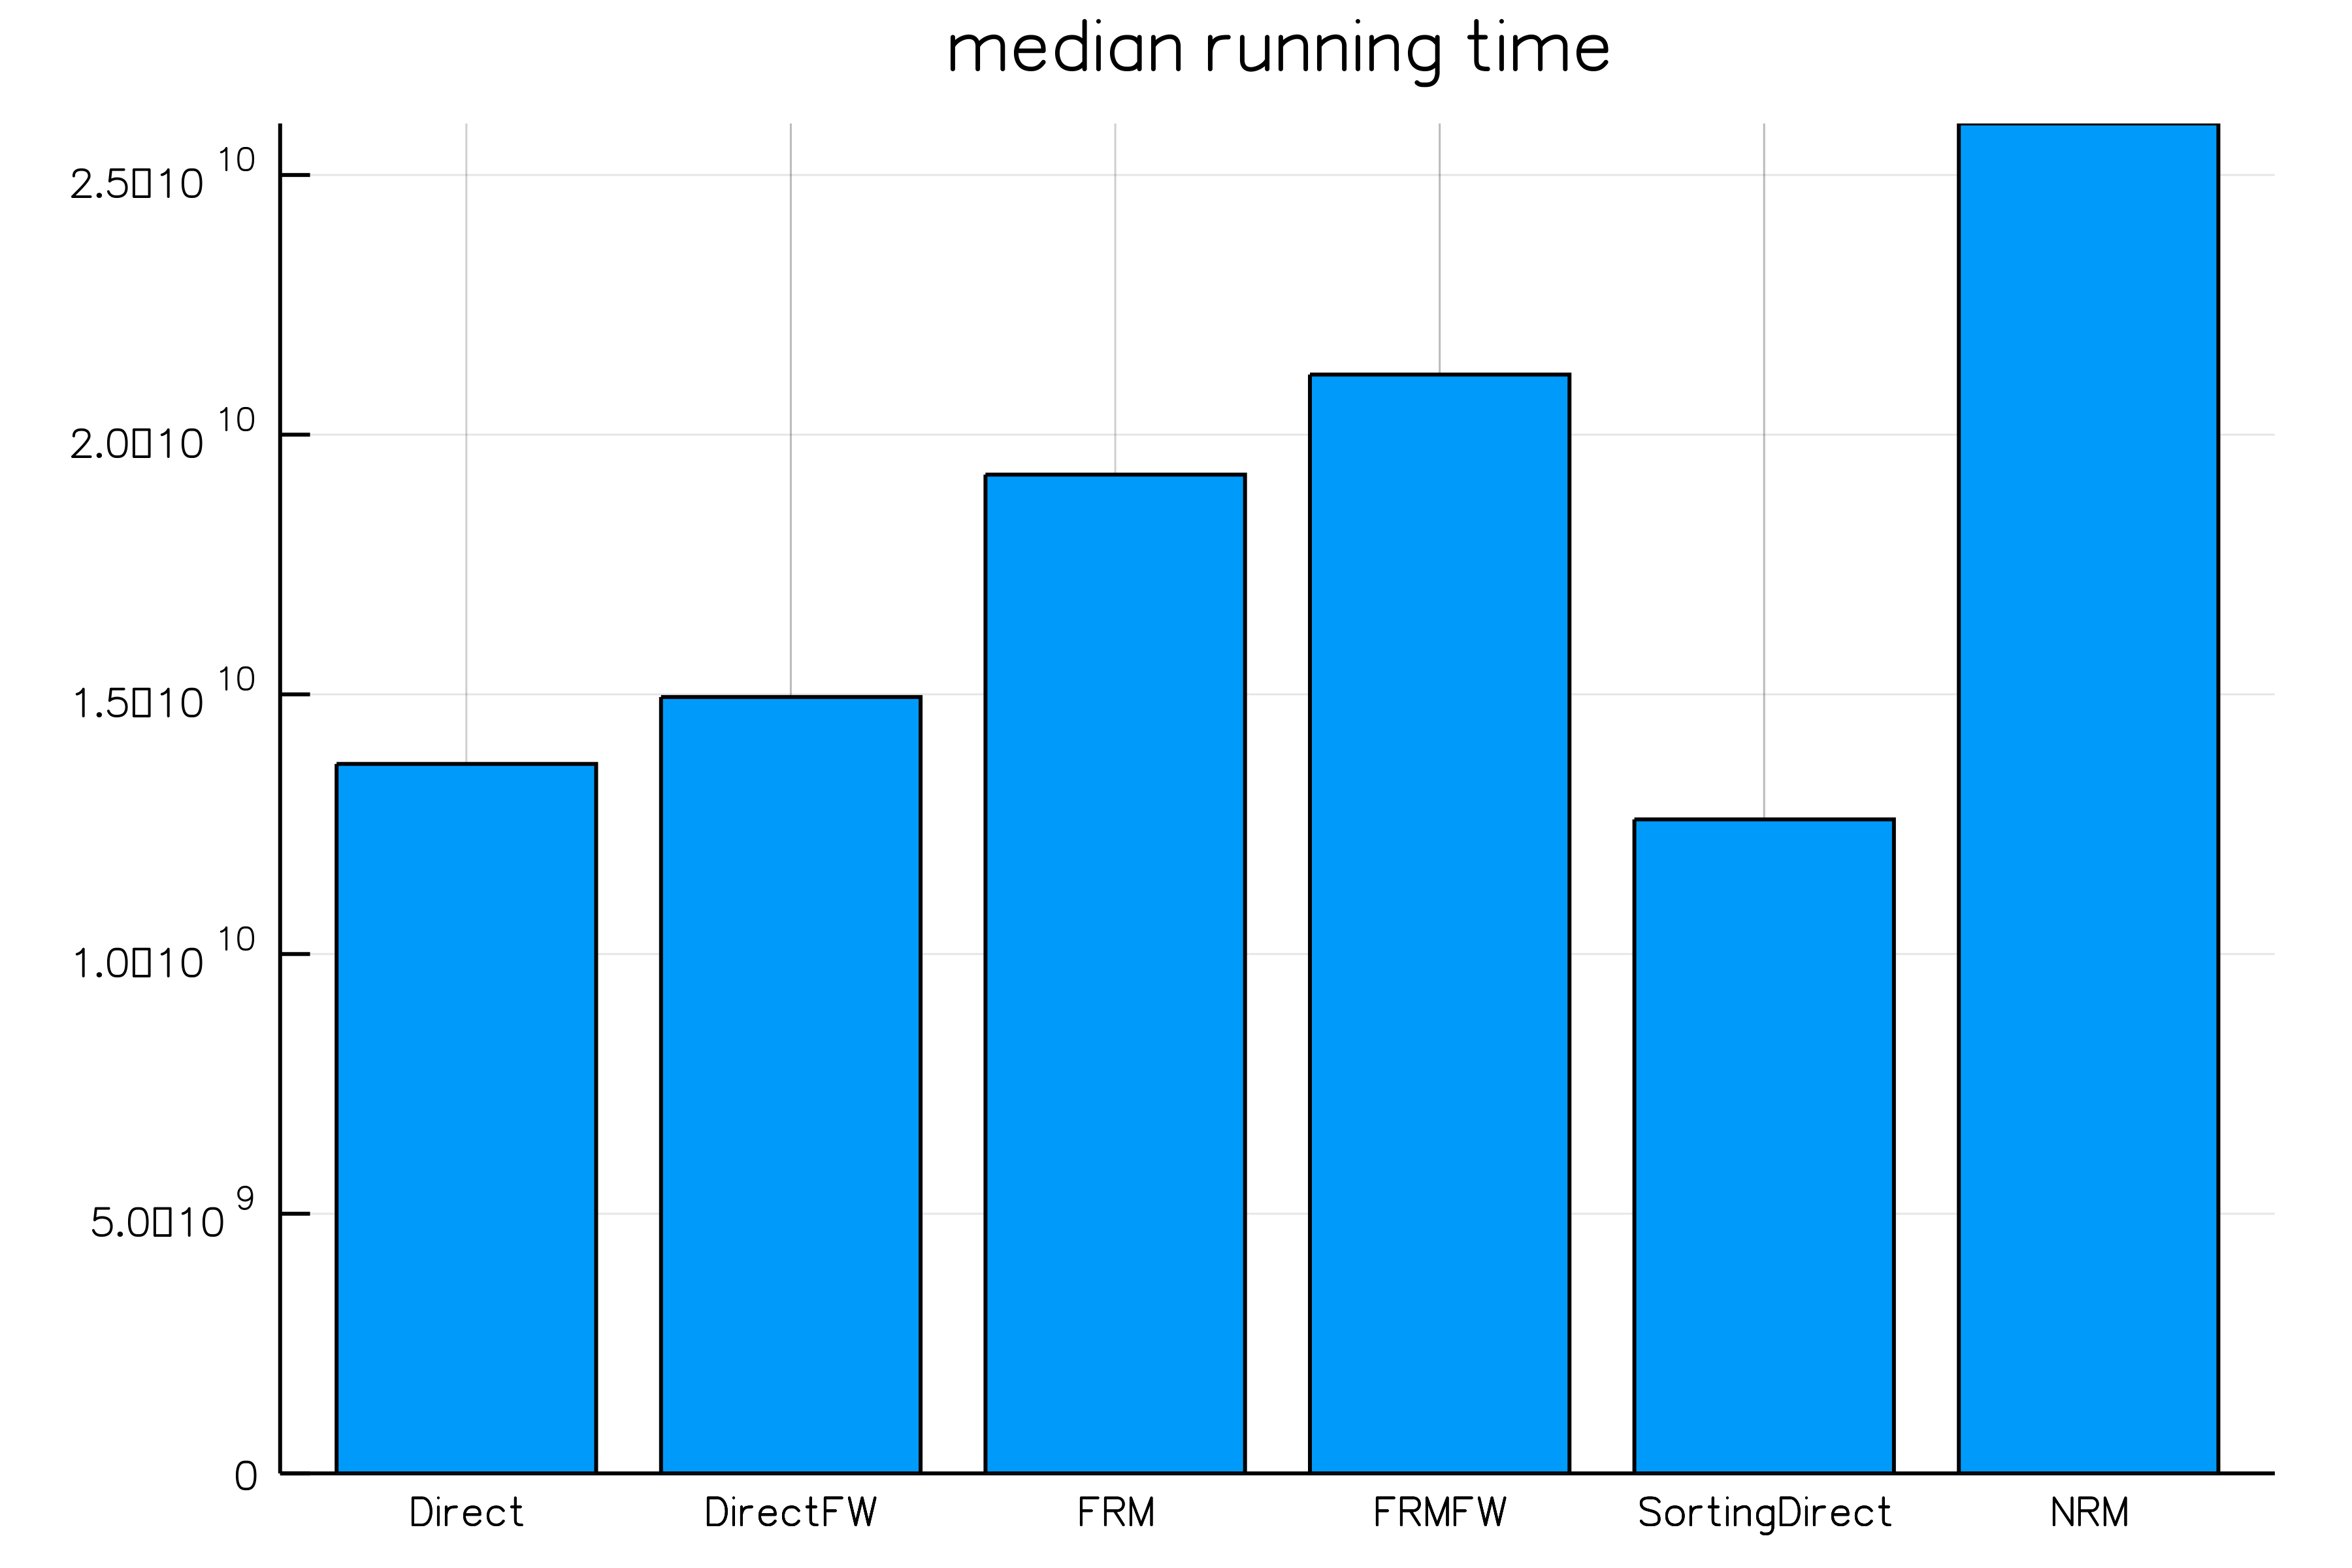

In [13]:
medtimes = [median(b.times) for b in benchmarks]
bar(shortlabels,medtimes,title="median running time",leg=false,format=fmt)

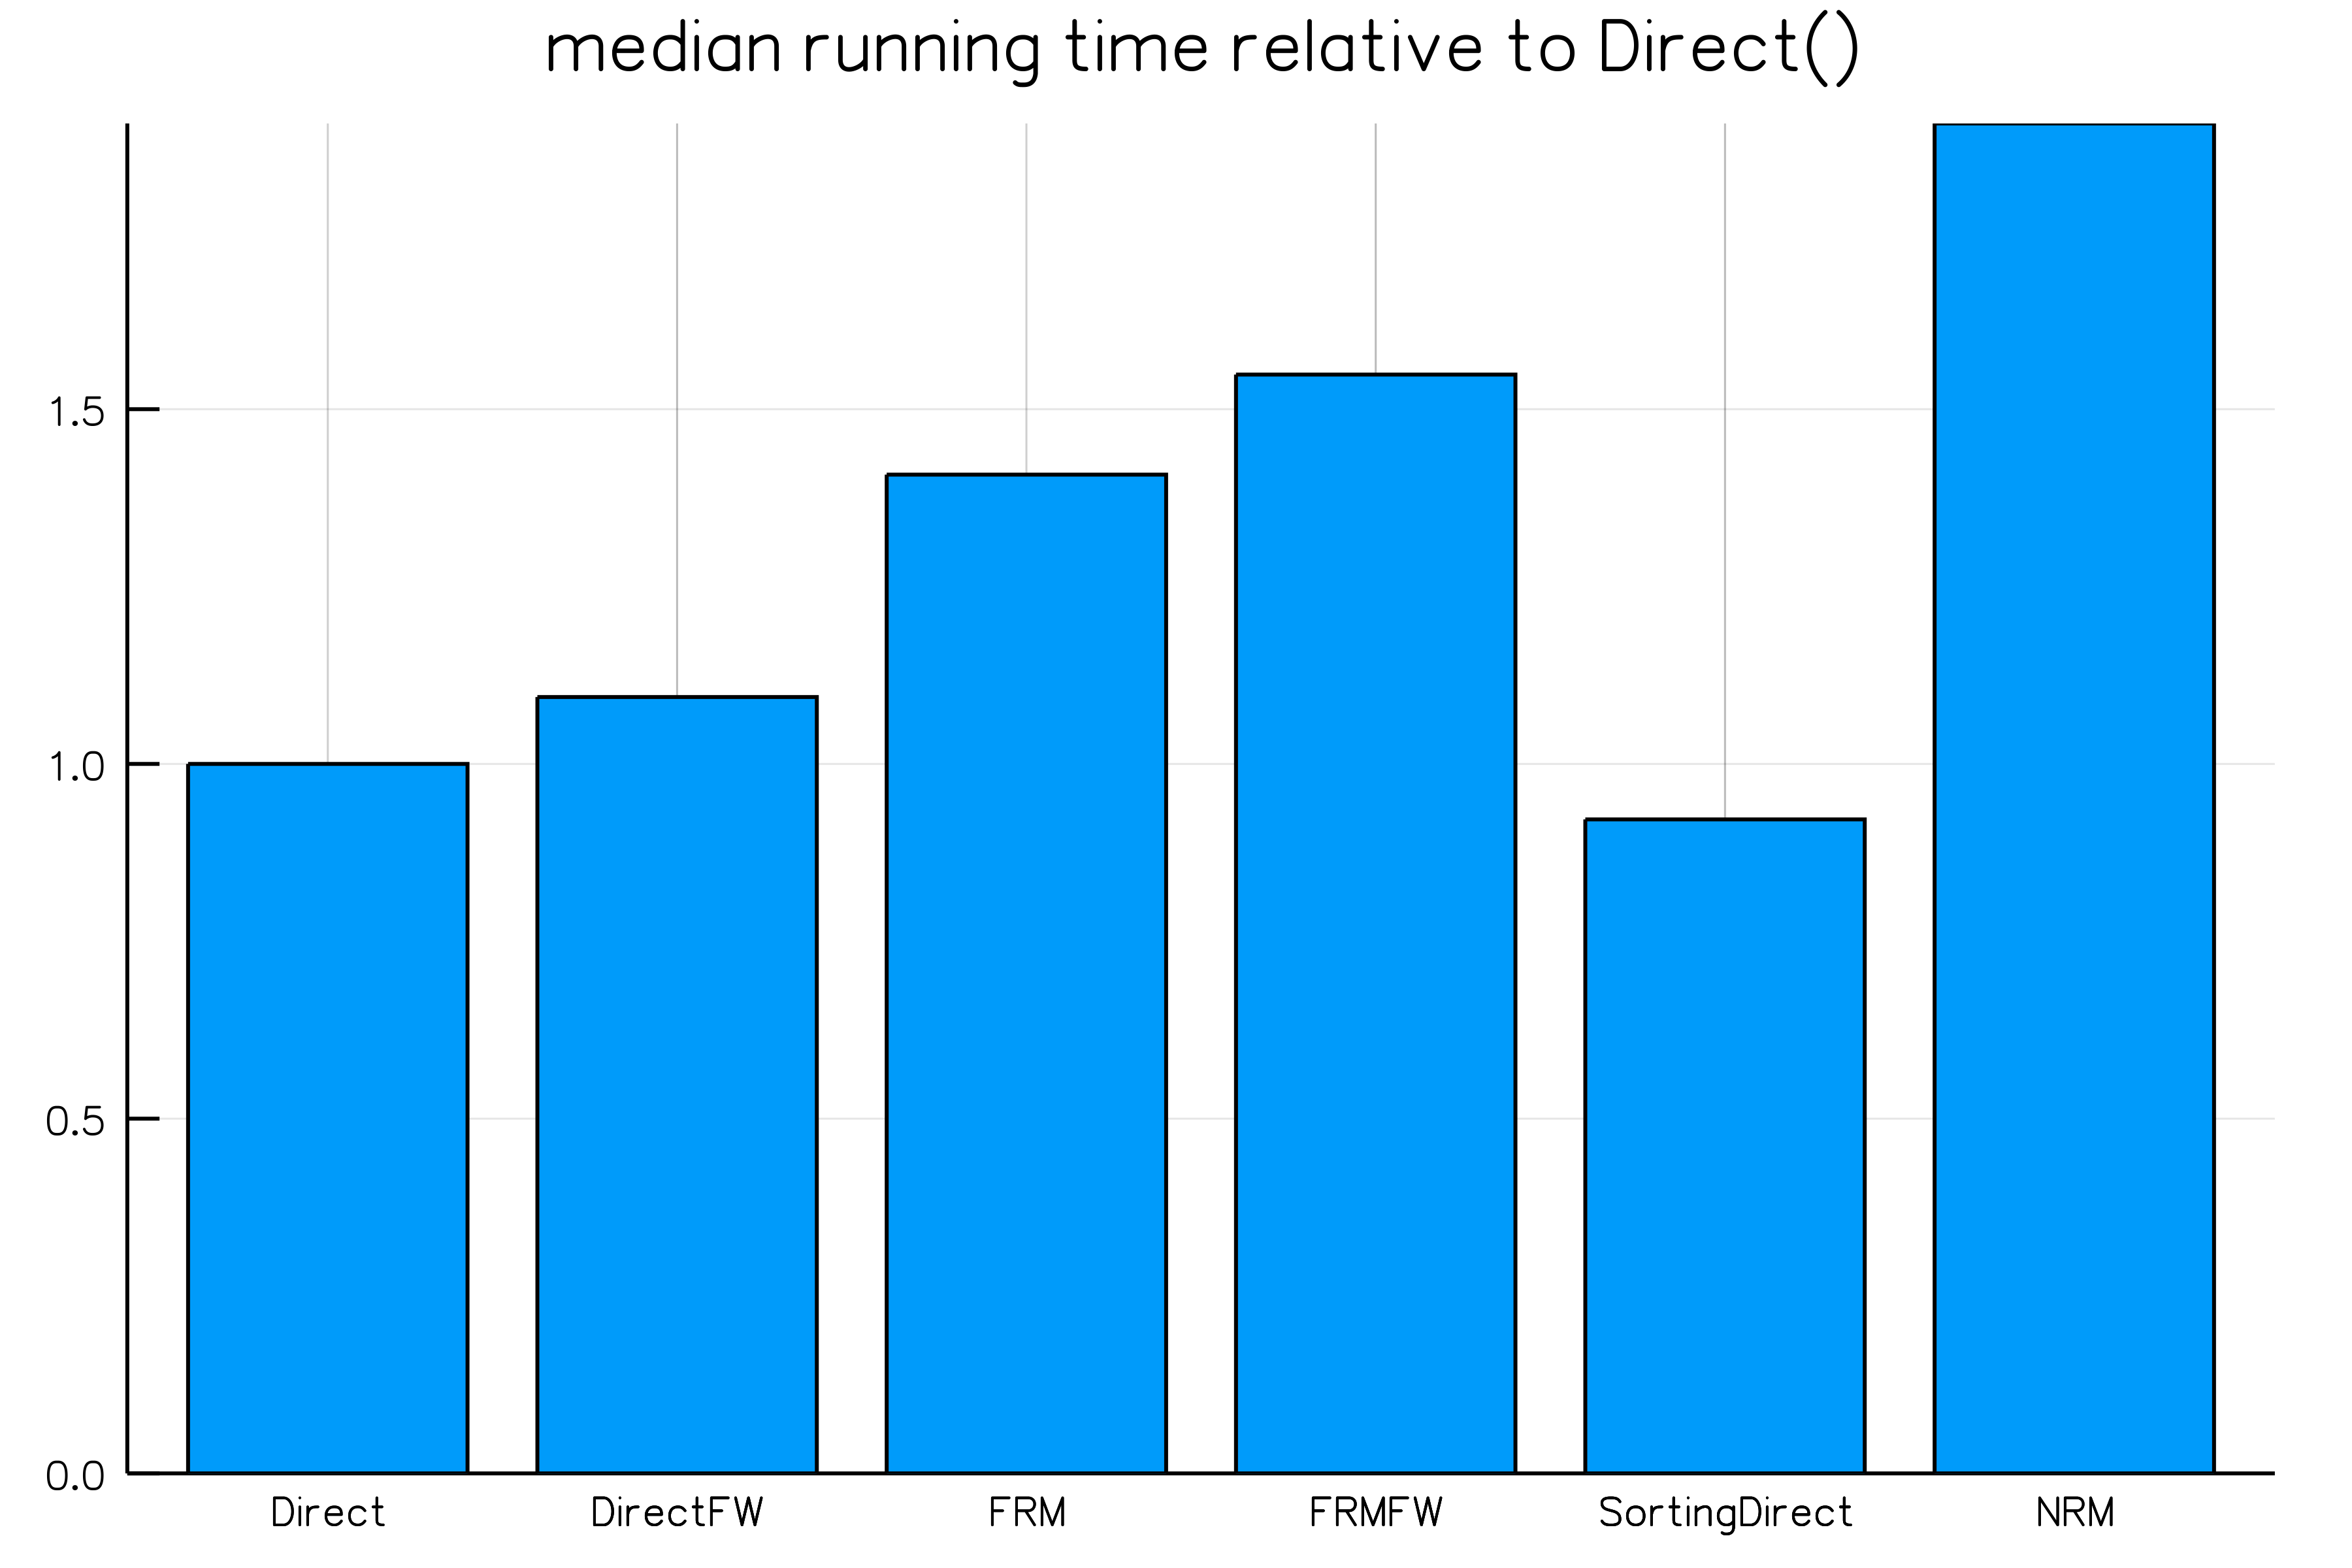

In [14]:
relmed = medtimes / medtimes[1]
bar(shortlabels,relmed,title="median running time relative to Direct()",leg=false,format=fmt)